In [1]:
# %load withholding.py
# %matplotlib notebook
import matplotlib as plt
import numpy as np
import pandas as pd

import seaborn as sns

# Apply the default theme
sns.set_theme()

df = pd.read_csv("../../data/withholding.tsv", sep="\t")
df = df.loc[:, ~df.columns.str.contains("^Unnamed")]


def parse_array(s):
    try:
        return np.fromstring(s, dtype=float, sep="|")
    except:
        return np.array([float("nan")])


def expand(row):
    compute = parse_array(row.compute)
    rcompute = compute / np.sum(compute)
    activations = parse_array(row.activations)
    assert np.sum(activations) == row.number_activations or row.error
    ractivations = activations / row.number_activations
    reward = parse_array(row.reward)
    rreward = reward / np.sum(reward)
    d = {}
    d["attack_space"] = row["strategy"].split("-")[0]
    d["policy"] = "-".join(row["strategy"].split("-")[1:])
    d["attacker_compute"] = rcompute[0]
    d["attacker_relative_activations"] = ractivations[0]
    d["attacker_relative_reward"] = rreward[0]
    d["attacker_gain"] = rreward[0] - ractivations[0]
    d["attacker_reward"] = reward[0]
    d["attacker_reward_per_time"] = reward[0] / row.ca_time
    # simulate DAA restrospectively. This method works only for zero network delays.
    d["da_observed_pow_interval"] = row.ca_time / (row.ca_height * row.k)
    d["da_target_pow_interval"] = 1
    d["da_ca_time"] = (
        row.ca_time / d["da_observed_pow_interval"] * d["da_target_pow_interval"]
    )
    d["da_attacker_reward_per_time"] = reward[0] / d["da_ca_time"]
    return d


df = df.join(df.apply(expand, axis=1, result_type="expand"))

d = df[df.protocol == "tailstorm"]
d = d[(d.incentive_scheme == "constant") | (d.incentive_scheme == "discount")]
d.columns

Index(['network', 'network_description', 'compute', 'protocol', 'k',
       'protocol_description', 'block_interval', 'activation_delay',
       'number_activations', 'activations', 'incentive_scheme',
       'incentive_scheme_description', 'strategy', 'strategy_description',
       'reward', 'ca_time', 'ca_height', 'machine_duration_s', 'error',
       'version', 'attack_space', 'policy', 'attacker_compute',
       'attacker_relative_activations', 'attacker_relative_reward',
       'attacker_gain', 'attacker_reward', 'attacker_reward_per_time',
       'da_observed_pow_interval', 'da_target_pow_interval', 'da_ca_time',
       'da_attacker_reward_per_time'],
      dtype='object')

In [2]:
d.pivot(
    index=["attacker_compute", "k"],
    columns=["strategy", "incentive_scheme"],
    values="attacker_relative_reward",
)

strategy            private-override-catchup            \
incentive_scheme                    constant  discount   
attacker_compute k                                       
0.10             1                  0.036364  0.036364   
                 2                  0.026385  0.026385   
                 4                  0.016314  0.015055   
                 8                  0.015749  0.014000   
                 16                 0.012147  0.011070   
                 32                 0.020058  0.018409   
                 64                 0.037788  0.034610   
0.20             1                  0.133083  0.133083   
                 2                  0.113885  0.113885   
                 4                  0.089199  0.082708   
                 8                  0.091707  0.082000   
                 16                 0.120088  0.106588   
                 32                 0.173913  0.160245   
                 64                 0.207923  0.199515   
0.25             1                  0.193392  0.193392   
                 2                  0.168675  0.168675   
                 4                  0.159102  0.149949   
                 8                  0.171731  0.157044   
                 16                 0.197938  0.178058   
                 32                 0.283865  0.269121   
                 64                 0.309874  0.303228   
0.33             1                  0.322344  0.322344   
                 2                  0.297820  0.297820   
                 4                  0.297733  0.285986   
                 8                  0.318269  0.301494   
                 16                 0.396069  0.382263   
                 32                 0.463201  0.465219   
                 64                 0.474941  0.477488   
0.40             1                  0.487113  0.487113   
                 2                  0.416986  0.416986   
                 4                  0.442329  0.435923   
                 8                  0.490385  0.482808   
                 16                 0.548054  0.551375   
                 32                 0.615827  0.642866   
                 64                 0.647624  0.676857   
0.45             1                  0.618532  0.618532   
                 2                  0.581715  0.581715   
                 4                  0.588340  0.586313   
                 8                  0.594751  0.597317   
                 16                 0.656555  0.680006   
                 32                 0.718909  0.764200   
                 64                 0.715332  0.764746   
0.50             1                  0.809403  0.809403   
                 2                  0.835024  0.835024   
                 4                  0.760649  0.763937   
                 8                  0.879455  0.891091   
                 16                 0.846274  0.875443   
                 32                 0.767857  0.817715   
                 64                 0.751379  0.810566   

strategy            private-override-block-alt            \
incentive_scheme                      constant  discount   
attacker_compute k                                         
0.10             1                    0.035937  0.035937   
                 2                    0.020879  0.020879   
                 4                    0.014797  0.013720   
                 8                    0.015625  0.014162   
                 16                   0.013053  0.011848   
                 32                   0.021464  0.019181   
                 64                   0.031582  0.029071   
0.20             1                    0.132690  0.132690   
                 2                    0.108932  0.108932   
                 4                    0.078606  0.072653   
                 8                    0.094363  0.081891   
                 16                   0.119975  0.103271   
                 32                   0.153931  0.137502   
                 64    

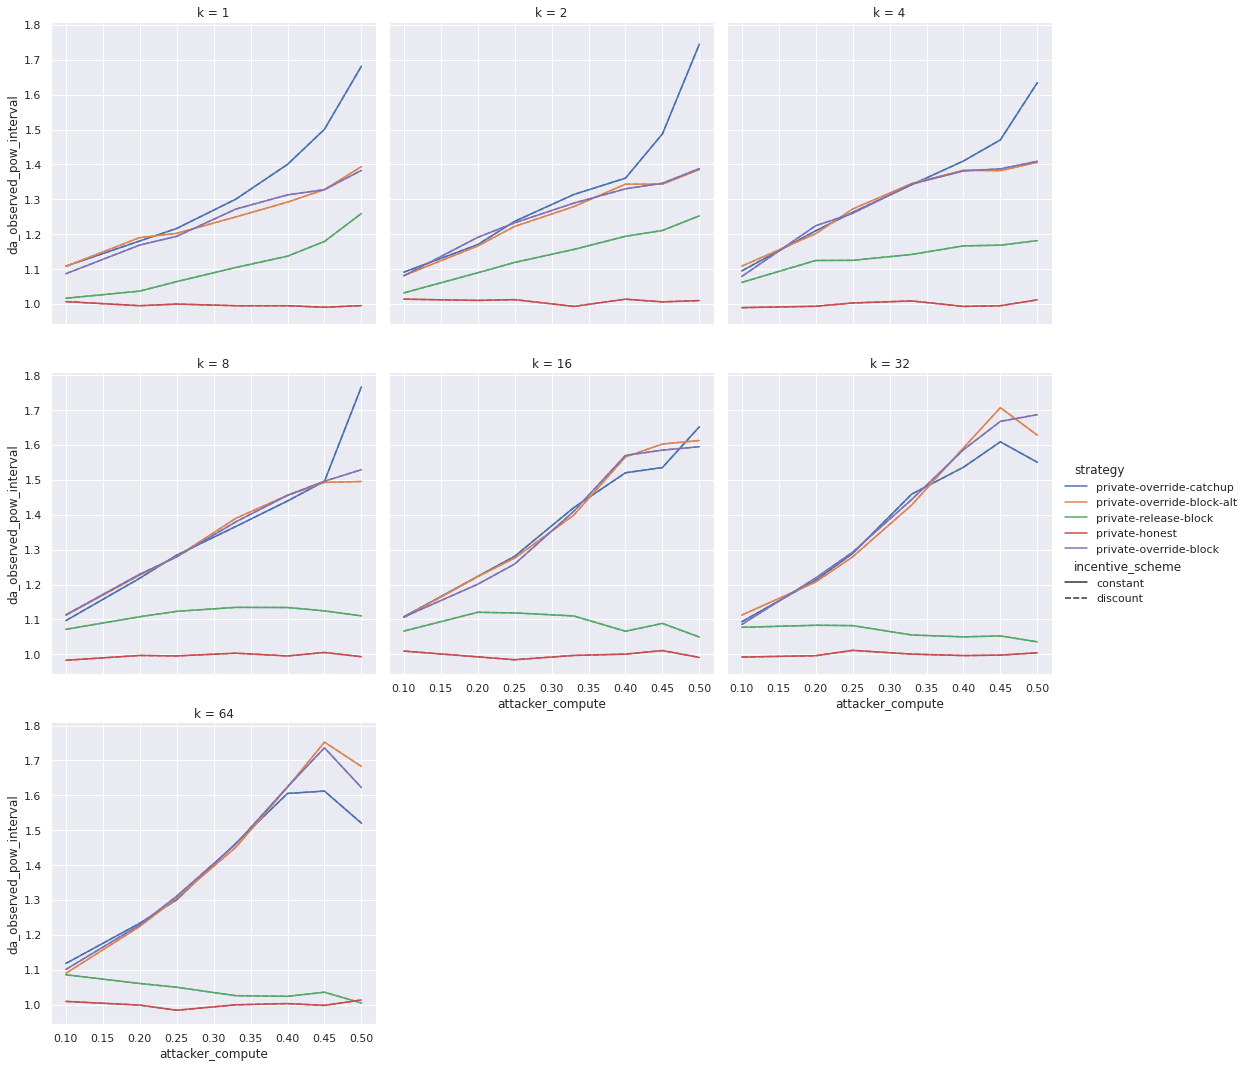

In [3]:
ax = sns.relplot(
    data=d[d.attack_space == "private"],
    x="attacker_compute",
    y="da_observed_pow_interval",
    col="k",
    col_wrap=3,
    hue="strategy",
    style="incentive_scheme",
    kind="line",
)

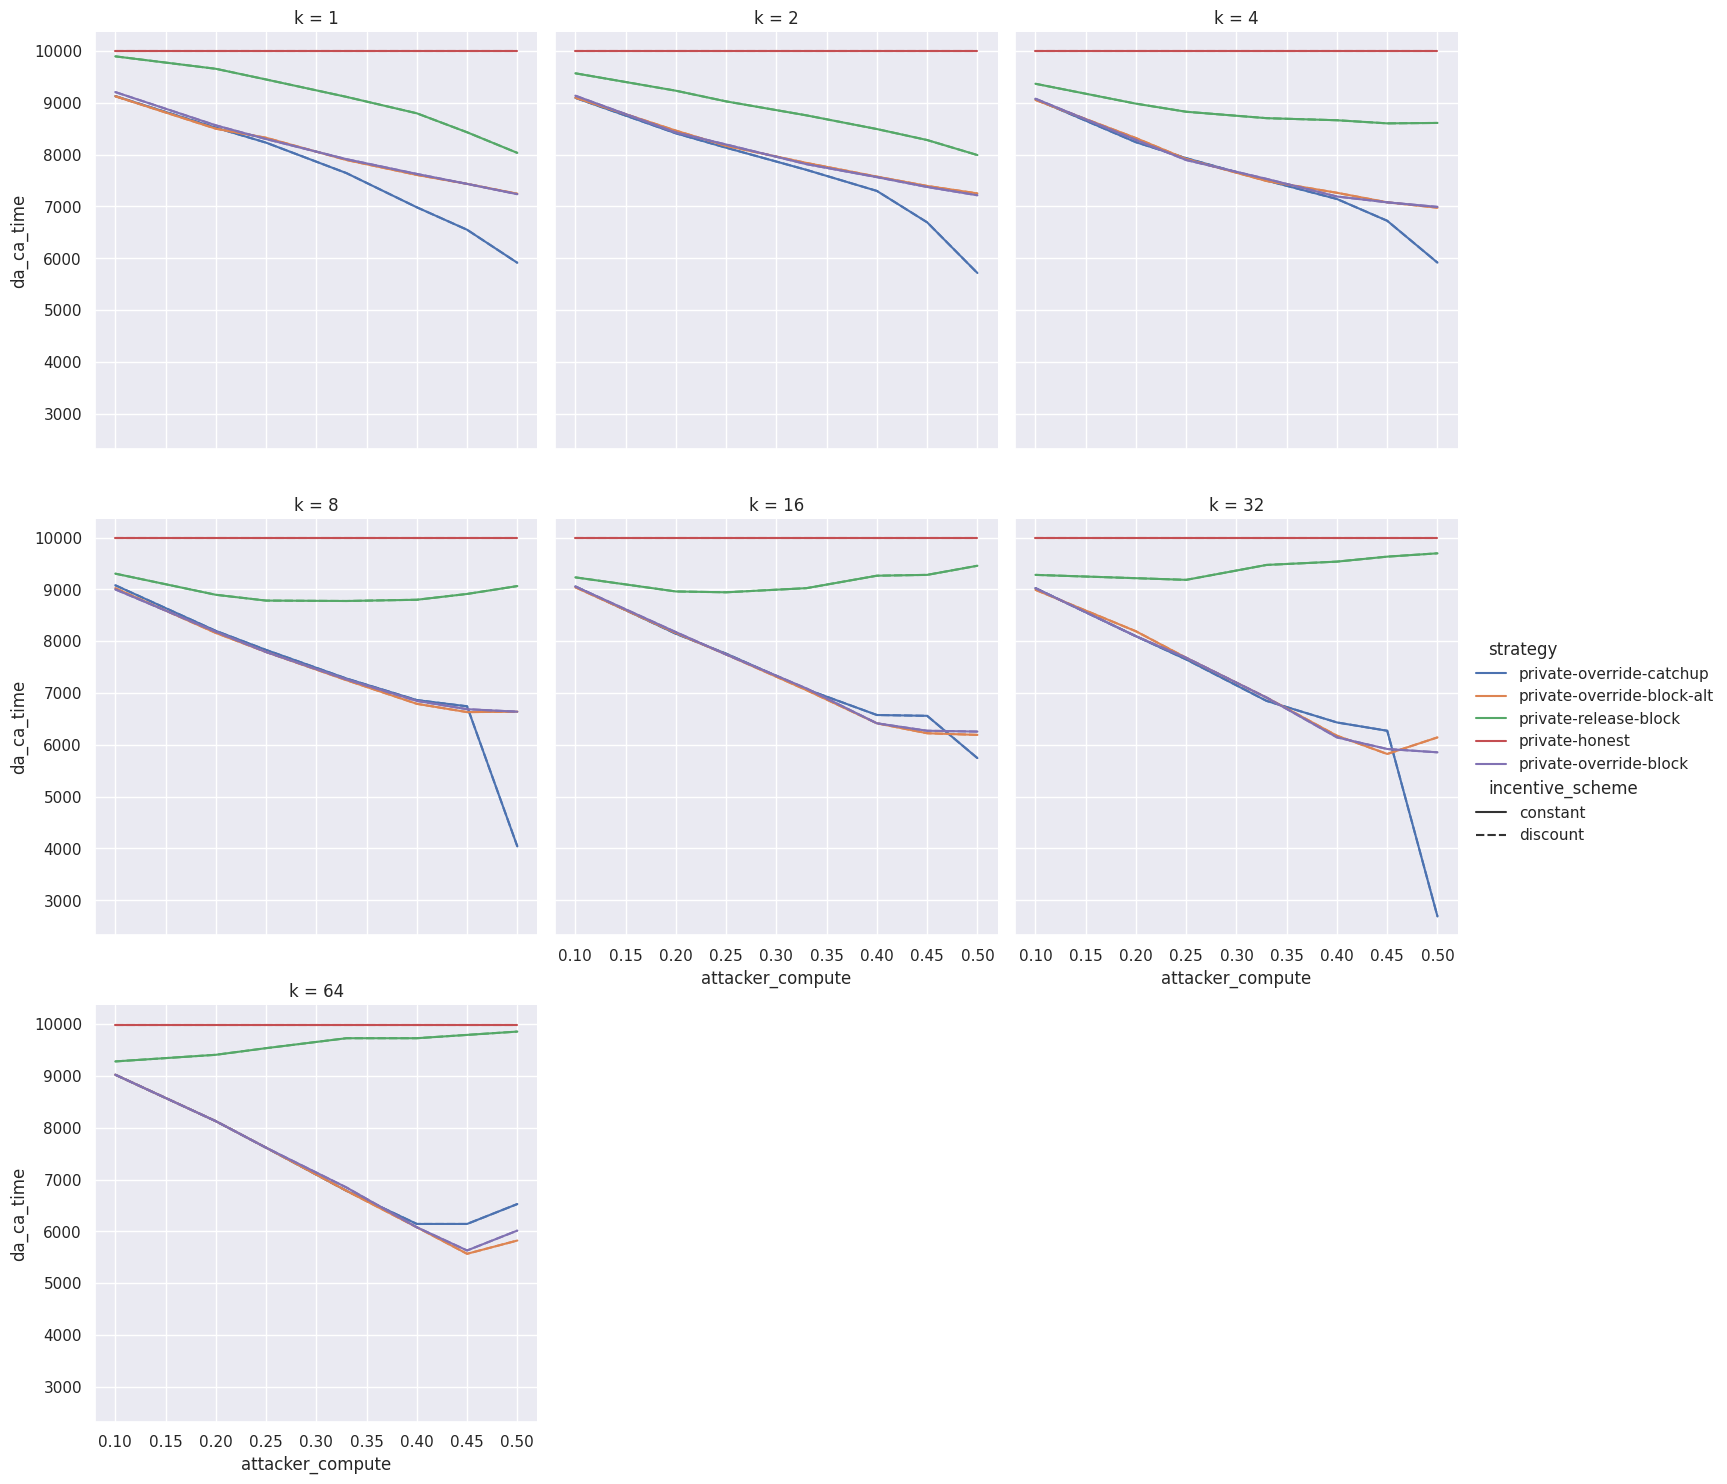

In [4]:
ax = sns.relplot(
    data=d[d.attack_space == "private"],
    x="attacker_compute",
    y="da_ca_time",
    col="k",
    col_wrap=3,
    hue="strategy",
    style="incentive_scheme",
    kind="line",
)

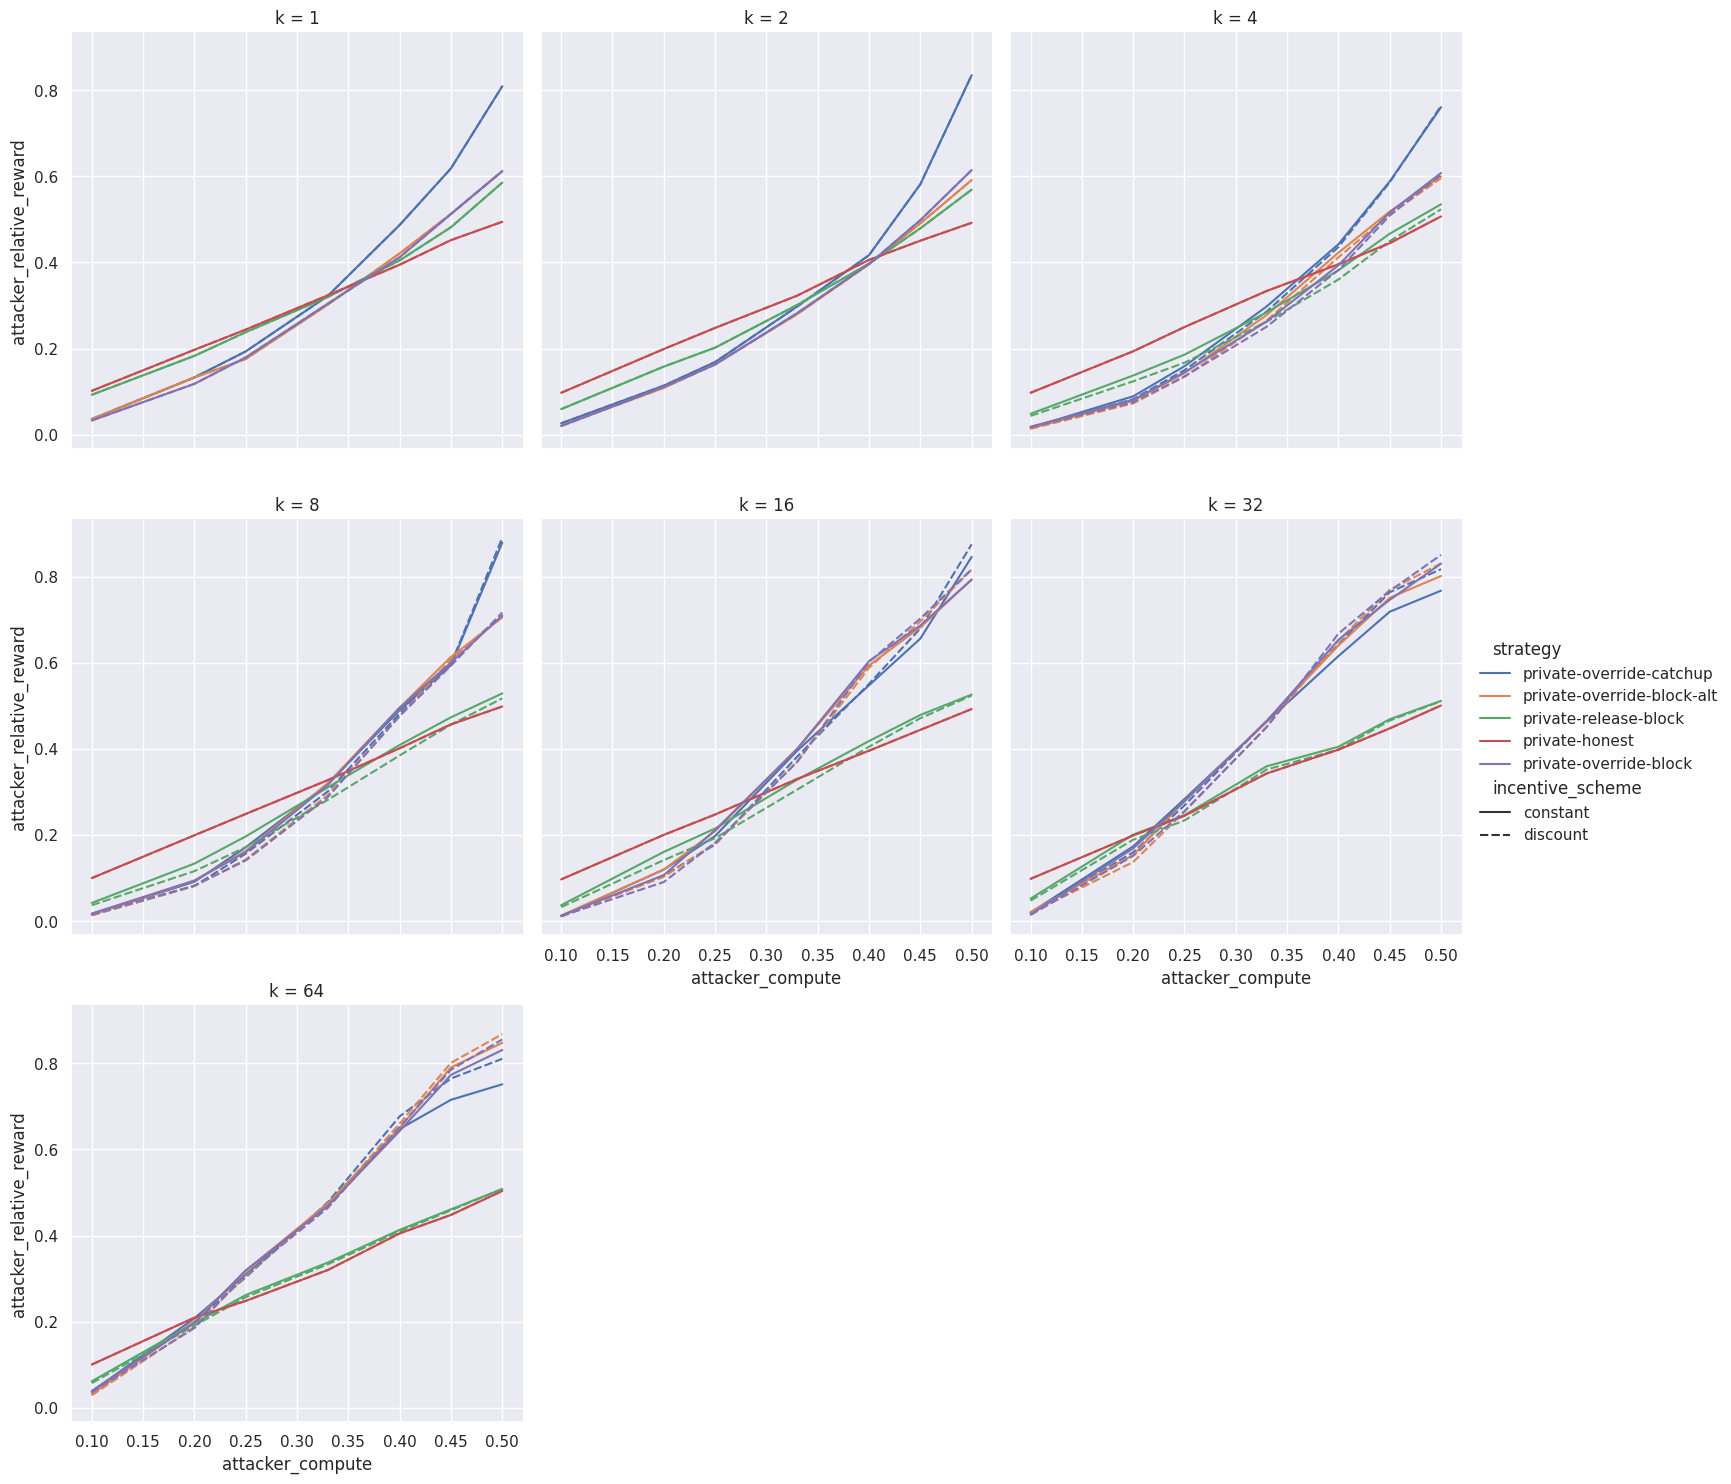

In [5]:
ax = sns.relplot(
    data=d[d.attack_space == "private"],
    x="attacker_compute",
    y="attacker_relative_reward",
    col="k",
    col_wrap=3,
    hue="strategy",
    style="incentive_scheme",
    kind="line",
)
ax.savefig("../../tex/george-reward-inequality/fig/withholding_relative.png")

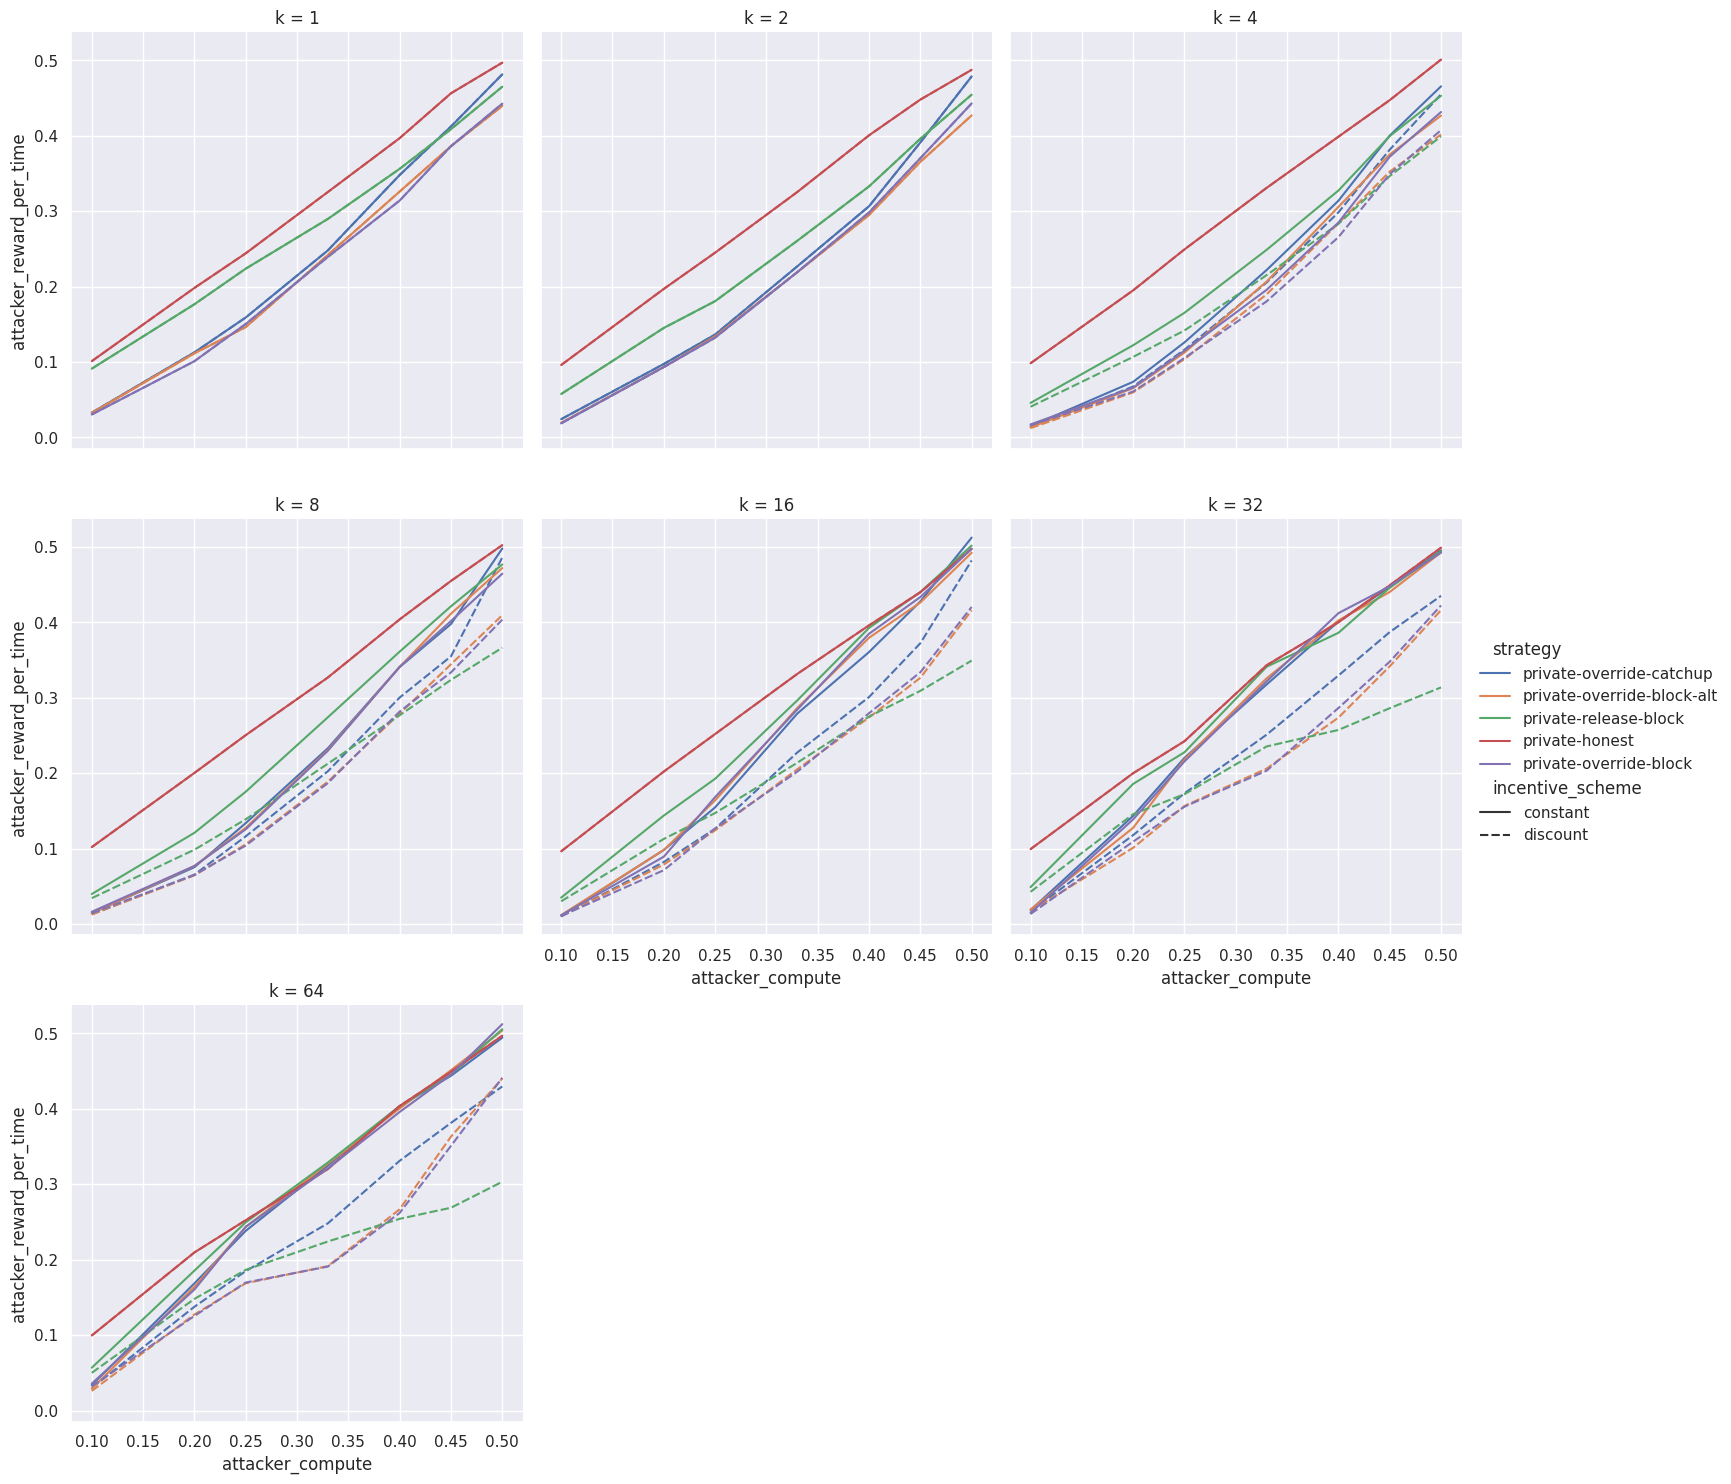

In [6]:
ax = sns.relplot(
    data=d[d.attack_space == "private"],
    x="attacker_compute",
    y="attacker_reward_per_time",
    col="k",
    col_wrap=3,
    hue="strategy",
    style="incentive_scheme",
    kind="line",
)
ax.savefig("../../tex/george-reward-inequality/fig/withholding_absolute.png")

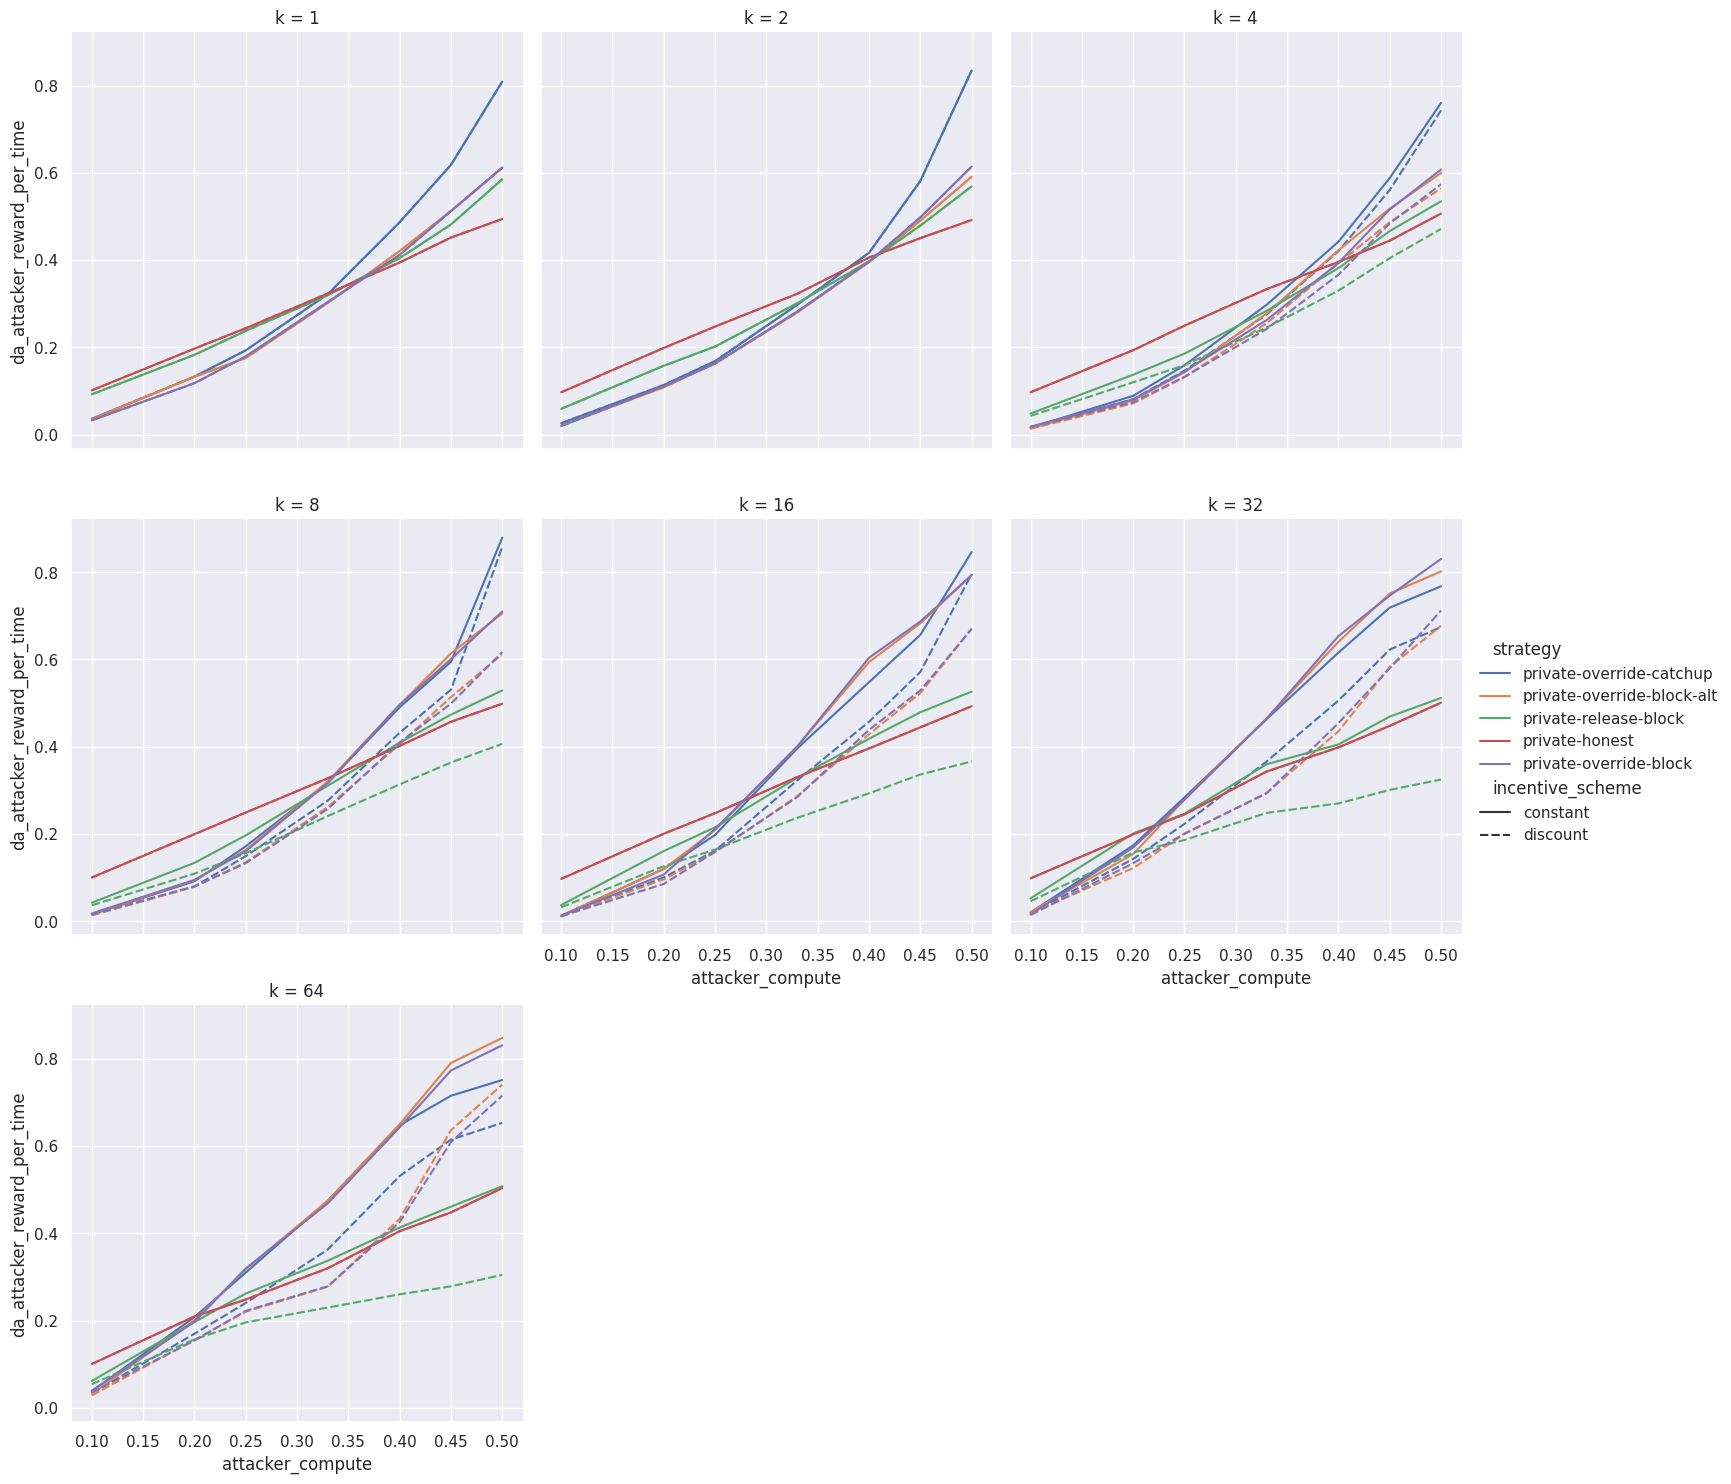

In [7]:
ax = sns.relplot(
    data=d[d.attack_space == "private"],
    x="attacker_compute",
    y="da_attacker_reward_per_time",
    col="k",
    col_wrap=3,
    hue="strategy",
    style="incentive_scheme",
    kind="line",
)
ax.savefig("../../tex/george-reward-inequality/fig/withholding_daa.png")

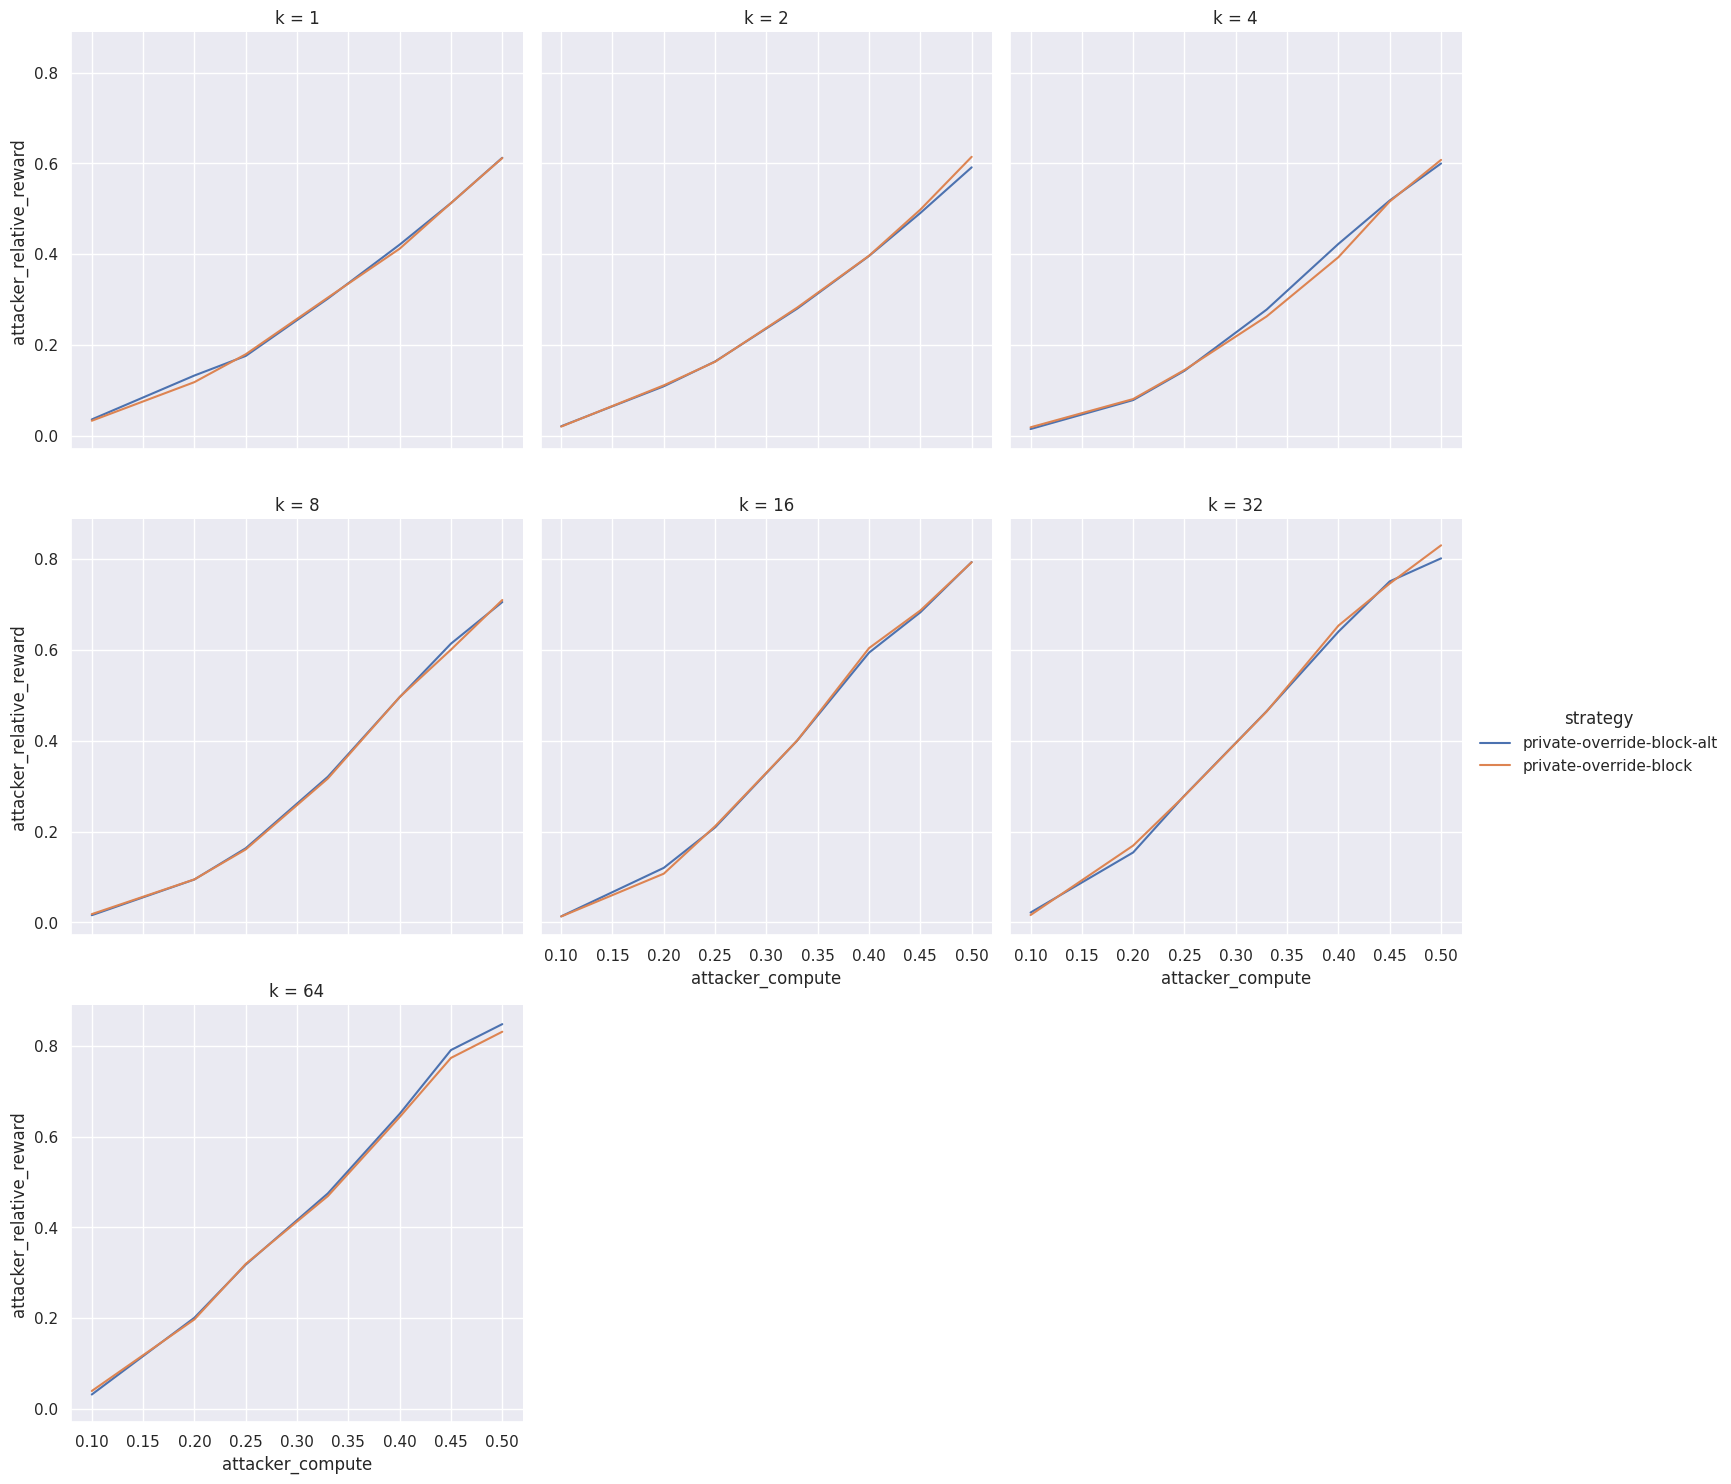

In [8]:
# does numerical implementation line up with non-numerical implementation of policiy?
dd = d
dd = dd[
    (dd["strategy"] == "private-override-block")
    | (dd["strategy"] == "private-override-block-alt")
]
dd = dd[(dd["incentive_scheme"] == "constant")]
sns.relplot(
    data=dd,
    x="attacker_compute",
    y="attacker_relative_reward",
    col="k",
    col_wrap=3,
    hue="strategy",
    kind="line",
)
# It does line up!

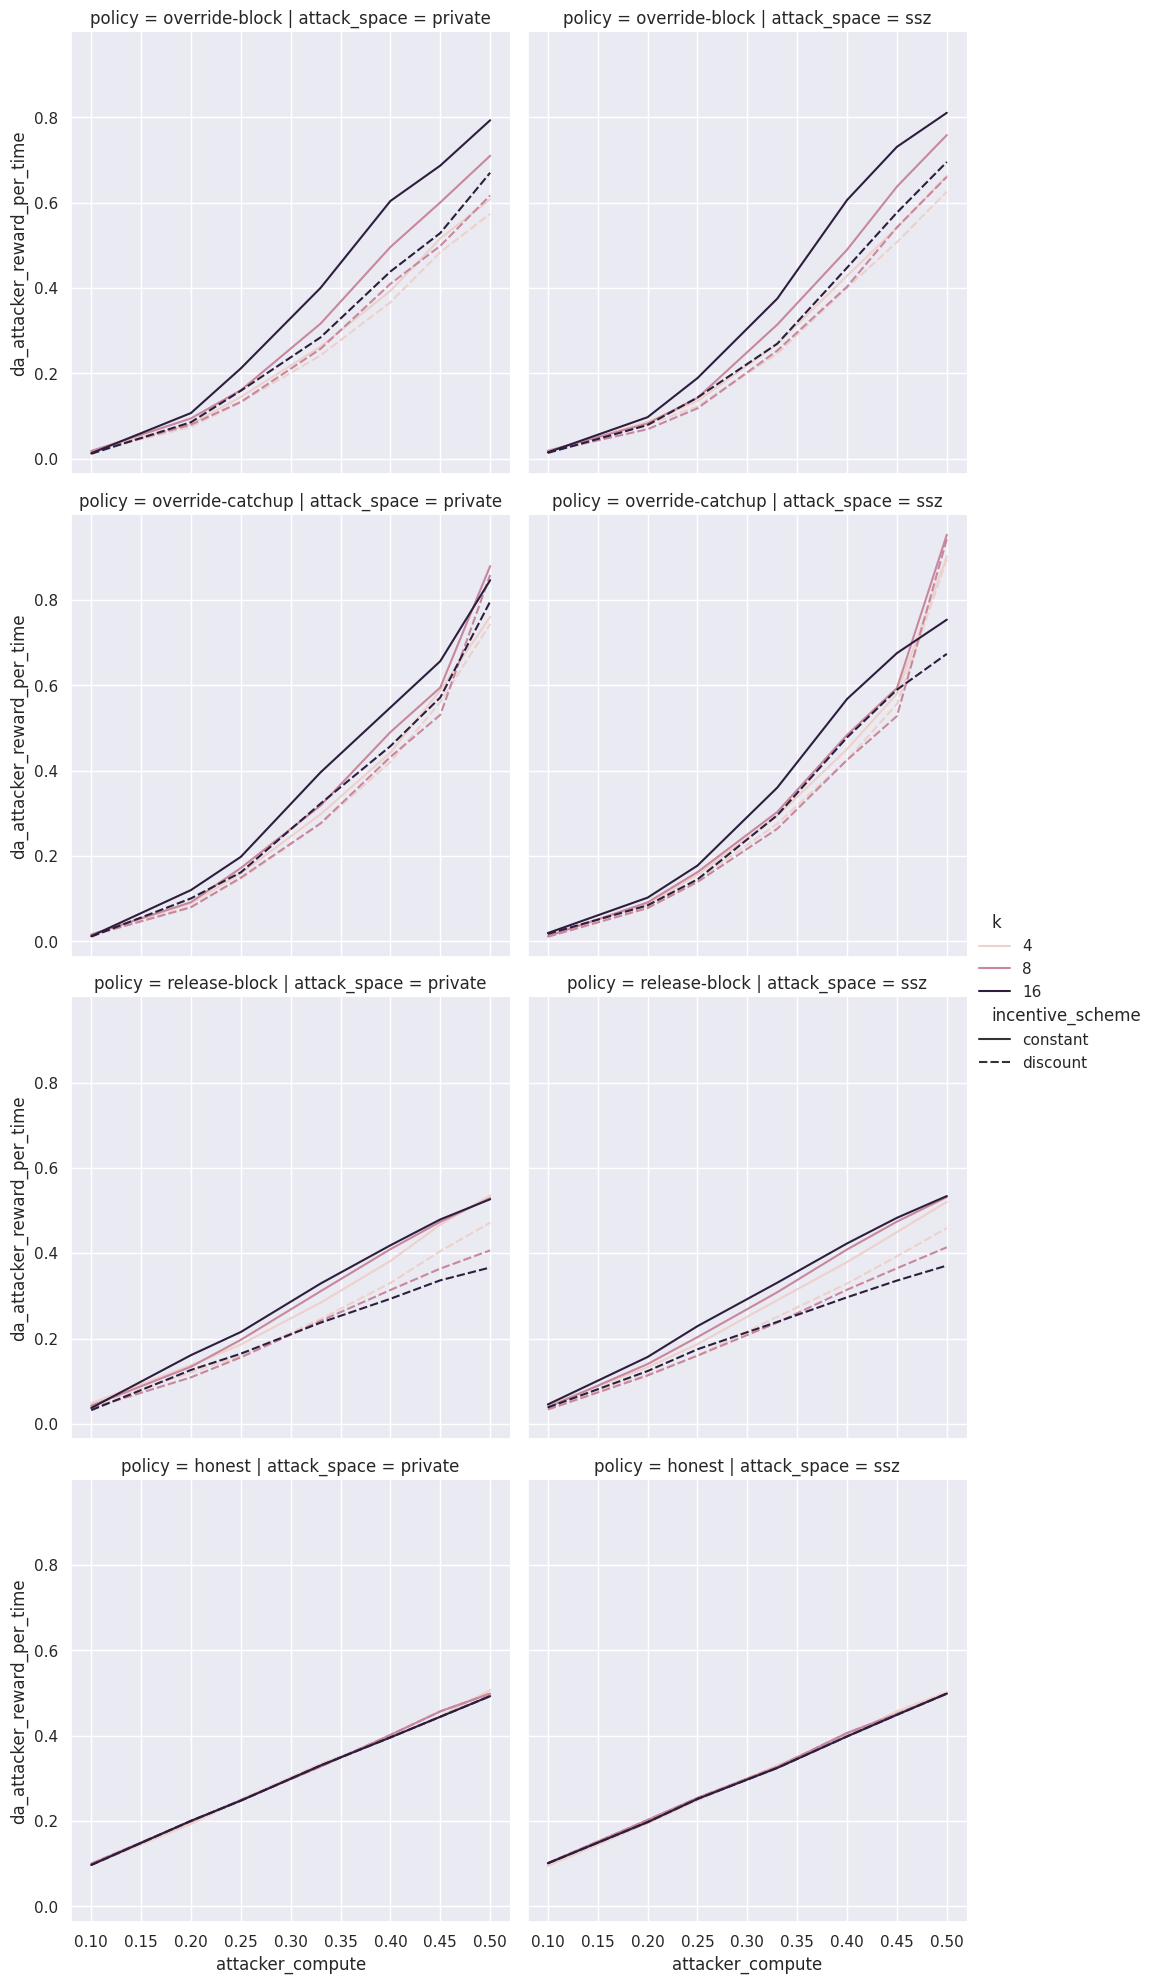

In [9]:
ax = sns.relplot(
    data=d[
        [
            k in [4, 8, 16] and policy != "override-block-alt"
            for k, policy in zip(d.k, d.policy)
        ]
    ],
    x="attacker_compute",
    y="da_attacker_reward_per_time",
    col="attack_space",
    row="policy",
    hue="k",
    style="incentive_scheme",
    kind="line",
)
ax.savefig("../../tex/george-reward-inequality/fig/withholding_daa.png")